# 假新聞分類與分析
- TF-IDF
- Word2Vec
- Sentence-BERT

In [32]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# 載入資料集
fake_df = pd.read_csv('./raw_data/fake.csv')
true_df = pd.read_csv('./raw_data/true.csv')

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前1000筆
data = pd.concat([fake_df.iloc[:1000], true_df.iloc[:1000]], ignore_index=True)
data = data[data['text'].notna()].reset_index(drop=True)

# 檢查各類別數量
print(data['label'].value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
1    1000
0    1000
Name: count, dtype: int64


In [33]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))
data.head(2)


,title,text,subject,date,label,tokens,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, wish, american, happy, new, ye...",donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...


## NER

In [34]:
from matplotlib.font_manager import fontManager
import matplotlib.pyplot as plt

fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [35]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 載入模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 建立 NER 結果列表
ner_rows = []

# 分切字串
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 針對每篇文章跑 NER（可用 tqdm 顯示進度條）
for idx, text in tqdm(data['text'].astype(str).items()):
    try:
        chunks = split_text(text)
        all_ents = []
        for chunk in chunks:
            all_ents.extend(ner_pipeline(chunk))  # 對每段跑 NER
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],  # e.g., PER, LOC
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f"Error at idx {idx}: {e}")

# 建立 DataFrame
ner_df = pd.DataFrame(ner_rows)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
2000it [13:55,  2.39it/s]


In [36]:
ner_df.head(10)


,index,entity,word,score
0,0,PER,Donald Trump,0.999043
1,0,MISC,Americans,0.998977
2,0,LOC,Country,0.512393
3,0,ORG,F,0.991836
4,0,ORG,##ake News Media,0.968911
5,0,PER,Angry Pants,0.864726
6,0,LOC,America,0.999604
7,0,ORG,Fake News Media,0.917655
8,0,LOC,America,0.999512
9,0,PER,Donald J. Trump,0.886408


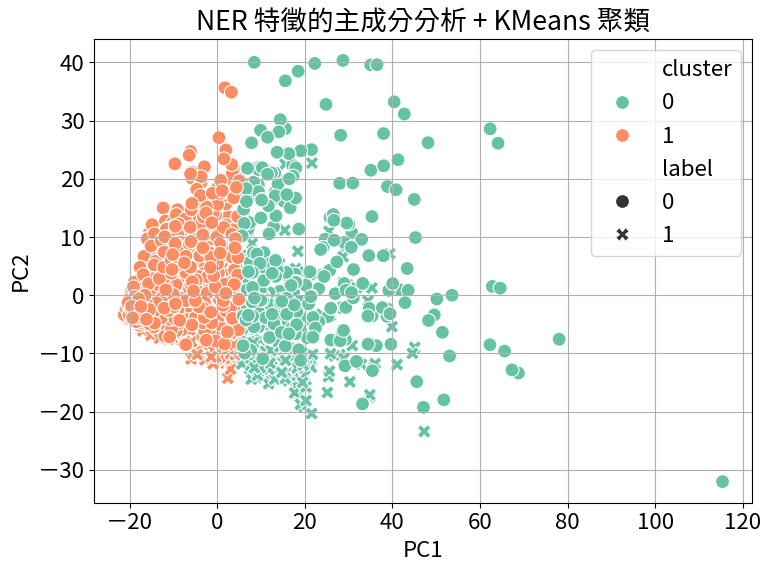

In [50]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 嘗試用 NER 提取出的'人名'、'組織'、'地名數量'作為詞彙特徵，再餵給 TF-IDF + 模型來預測這篇新聞是真/假

In [51]:
# 聚合 ner_df 結果為特徵表（以 index = 文章編號為 key）
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)

# 合併回原資料集
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

# 建立特徵：人名、組織、地名數量
X = data_with_ner[['PER', 'ORG', 'LOC']]
y = data_with_ner['label']

# 建模
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       201
           1       0.66      0.74      0.70       199

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



模型分辨力有點低?

## Text Clustering 與 真假新聞分辨

### Topic model: BERTopic 主題詞來源使用c-TF-IDF頻率導向，表現方式偏向詞頻高的詞

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

# 真假新聞進行主題建模
docs = data['text'].astype(str).tolist()

# 模型可換成 'all-MiniLM-L6-v2', 'microsoft/Phi-4-mini-instruct' 等
embedding_model = 'all-MiniLM-L6-v2'

# 可調整 測試用2000筆
# min_cluster_size 群集最少需要包含幾個點，否則會被視為雜訊（noise）
# min_samples 包含至少n篇文章的主題才會被承認為主題
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=30) # Clustering layer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)


In [60]:
# 建立一個儲存所有主題關鍵詞與 TF-IDF 分數的清單
all_topics = []

# 把主題總數拿出來（排除 -1 是未分類主題）
valid_topics = [topic for topic in topic_model.get_topic_info().Topic if topic != -1]

# 對每個主題取得詞與 c-TF-IDF 分數
for topic_id in valid_topics:
    topic_words = topic_model.get_topic(topic_id)
    for word, score in topic_words:
        all_topics.append({
            "Topic": topic_id,
            "Word": word,
            "C-TF-IDF": score
        })

# 轉換成 DataFrame 並排序
tfidf_df = pd.DataFrame(all_topics)
tfidf_df = tfidf_df.sort_values(by=["Topic", "C-TF-IDF"], ascending=[True, False])

# 顯示前幾列
tfidf_df.head(20)

,Topic,Word,C-TF-IDF
0,0,trump,0.031944
1,0,campaign,0.018928
2,0,russian,0.018505
3,0,russia,0.017711
4,0,mueller,0.016561
5,0,manafort,0.016173
6,0,said,0.015626
7,0,investigation,0.013164
8,0,donald,0.011244
9,0,clinton,0.011143


In [62]:

# 列出文章的BERTopic資訊
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Donald Trump just couldn t wish all Americans ...,2,2_trump_twitter_donald_donald trump,"[trump, twitter, donald, donald trump, news, p...","[Sunday morning, presumably just before church...",trump - twitter - donald - donald trump - news...,0.890172,False
1,House Intelligence Committee Chairman Devin Nu...,0,0_trump_campaign_russian_russia,"[trump, campaign, russian, russia, mueller, ma...",[WASHINGTON (Reuters) - U.S. Attorney General ...,trump - campaign - russian - russia - mueller ...,0.814355,False
2,"On Friday, it was revealed that former Milwauk...",4,4_white_trump_people_charlottesville,"[white, trump, people, charlottesville, just, ...",[Donald Trump held a bizarre press conference ...,white - trump - people - charlottesville - jus...,0.327949,False
3,"On Christmas day, Donald Trump announced that ...",2,2_trump_twitter_donald_donald trump,"[trump, twitter, donald, donald trump, news, p...","[Sunday morning, presumably just before church...",trump - twitter - donald - donald trump - news...,0.959027,False
4,Pope Francis used his annual Christmas Day mes...,-1,-1_trump_said_president_house,"[trump, said, president, house, republican, do...",[WASHINGTON/LONDON (Reuters) - President Donal...,trump - said - president - house - republican ...,0.000000,False
...,...,...,...,...,...,...,...,...
1995,WASHINGTON (Reuters) - A U.S. congressional co...,1,1_trump_said_people_puerto,"[trump, said, people, puerto, administration, ...",[NEW YORK (Reuters) - Many of the immigration ...,trump - said - people - puerto - administratio...,1.000000,False
1996,WASHINGTON (Reuters) - U.S. President Donald T...,0,0_trump_campaign_russian_russia,"[trump, campaign, russian, russia, mueller, ma...",[WASHINGTON (Reuters) - U.S. Attorney General ...,trump - campaign - russian - russia - mueller ...,0.764036,False
1997,WASHINGTON (Reuters) - U.S. Secretary of State...,9,9_tillerson_said_state_department,"[tillerson, said, state, department, state dep...",[WASHINGTON (Reuters) - U.S. President Donald ...,tillerson - said - state - department - state ...,0.341145,False
1998,WASHINGTON (Reuters) - Former CIA director Jam...,0,0_trump_campaign_russian_russia,"[trump, campaign, russian, russia, mueller, ma...",[WASHINGTON (Reuters) - U.S. Attorney General ...,trump - campaign - russian - russia - mueller ...,1.000000,False


In [70]:
def visualize_fake_news_ratio_by_topic(model, docs, labels, title="主題的假新聞比例"):
    doc_info = model.get_document_info(docs).copy()
    doc_info['label'] = labels

    # 計算比例與數量
    topic_fake_ratio = (
        doc_info[doc_info['Topic'] != -1]
        .groupby('Topic')['label']
        .mean()
        .reset_index()
        .rename(columns={'label': 'fake_news_ratio'})
    )
    topic_counts = (
        doc_info[doc_info['Topic'] != -1]['Topic']
        .value_counts()
        .rename_axis('Topic')
        .reset_index(name='count')
    )
    topic_stats = pd.merge(topic_fake_ratio, topic_counts, on='Topic')

    # 加上主題名稱
    topic_names = model.get_topic_info()[['Topic', 'Name']]
    topic_stats_named = topic_stats.merge(topic_names, on='Topic')

    # 過濾比例過低的主題
    topic_stats_named = topic_stats_named[topic_stats_named['fake_news_ratio'] >= 0.1]

    # 繪圖
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=topic_stats_named.sort_values(by='fake_news_ratio', ascending=False),
        x='fake_news_ratio', y='Name', palette='Reds'
    )
    plt.title(title)
    plt.xlabel('假新聞比例 (label=1)')
    plt.ylabel('主題代表詞')
    plt.grid(True, axis='x')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    plt.tight_layout()
    plt.show()

### representation topic model: 加上語意導向的KeyBERT, 表現方式是語意向量相似的詞 

In [72]:
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer

embedding_model_with_st = SentenceTransformer(embedding_model)  # 或其他你指定的模型
embeddings = embedding_model_with_st.encode(docs, show_progress_bar=True)

# 關鍵詞表示模型（非生成式）
keybert = KeyBERTInspired()

# 組裝 representation model
representation_model = {
    "KeyBERT": keybert
}

# 建立 BERTopic 模型（用 KeyBERT 調整主題表示）
representation_topic_model = BERTopic(
    embedding_model=embedding_model_with_st,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    top_n_words=30,
    verbose=True
)

# 訓練模型
topics, probs = representation_topic_model.fit_transform(docs, embeddings)

# 查看新的主題表示
representation_topic_model.get_topic_info()

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-05-10 13:15:08,534 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 13:15:11,602 - BERTopic - Dimensionality - Completed ✓
2025-05-10 13:15:11,603 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 13:15:11,647 - BERTopic - Cluster - Completed ✓
2025-05-10 13:15:11,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 13:15:16,651 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,531,-1_trump_said_president_donald,"[trump, said, president, donald, donald trump,...","[mueller, trump campaign, putin, trump, invest...",[WASHINGTON (Reuters) - An obscure Trump campa...
1,0,184,0_trump_twitter_news_donald,"[trump, twitter, news, donald, donald trump, p...","[trump realdonaldtrump, trump, realdonaldtrump...","[Sunday morning, presumably just before church..."
2,1,172,1_tax_percent_senate_house,"[tax, percent, senate, house, said, republican...","[tax cut, tax cuts, tax legislation, republica...",[(Reuters) - Republicans in the U.S. Congress ...
3,2,147,2_white_trump_people_charlottesville,"[white, trump, people, charlottesville, just, ...","[white supremacist, white supremacists, white ...",[Donald Trump held a bizarre press conference ...
4,3,114,3_north_korea_china_north korea,"[north, korea, china, north korea, trump, said...","[pyongyang, north korea, kim jong, north korea...",[BEIJING (Reuters) - U.S. President Donald Tru...
5,4,109,4_puerto_puerto rico_rico_trump,"[puerto, puerto rico, rico, trump, hurricane, ...","[puerto rico, rico, puerto, hurricane harvey, ...",[WASHINGTON (Reuters) - Two members of Preside...
6,5,83,5_trump_court_ban_said,"[trump, court, ban, said, administration, immi...","[travel ban, trump administration, supreme cou...",[WASHINGTON (Reuters) - The White House asked ...
7,6,79,6_obamacare_health_insurance_healthcare,"[obamacare, health, insurance, healthcare, car...","[repeal obamacare, obamacare, trumpcare, healt...",[WASHINGTON (Reuters) - The sweeping tax overh...
8,7,74,7_moore_alabama_roy_roy moore,"[moore, alabama, roy, roy moore, allegations, ...","[roy moore, moore, said moore, alabama republi...",[WASHINGTON (Reuters) - U.S. Senate Majority L...
9,8,67,8_mueller_trump_investigation_clinton,"[mueller, trump, investigation, clinton, fbi, ...","[mueller investigation, mueller, robert muelle...",[WASHINGTON (Reuters) - Democrats in the U.S. ...


In [73]:
# 視覺化主題分布：圓圈大小是主題的大小，圓圈的距離是主題之間的相似度
topic_model.visualize_topics()

In [74]:
representation_topic_model.visualize_topics()

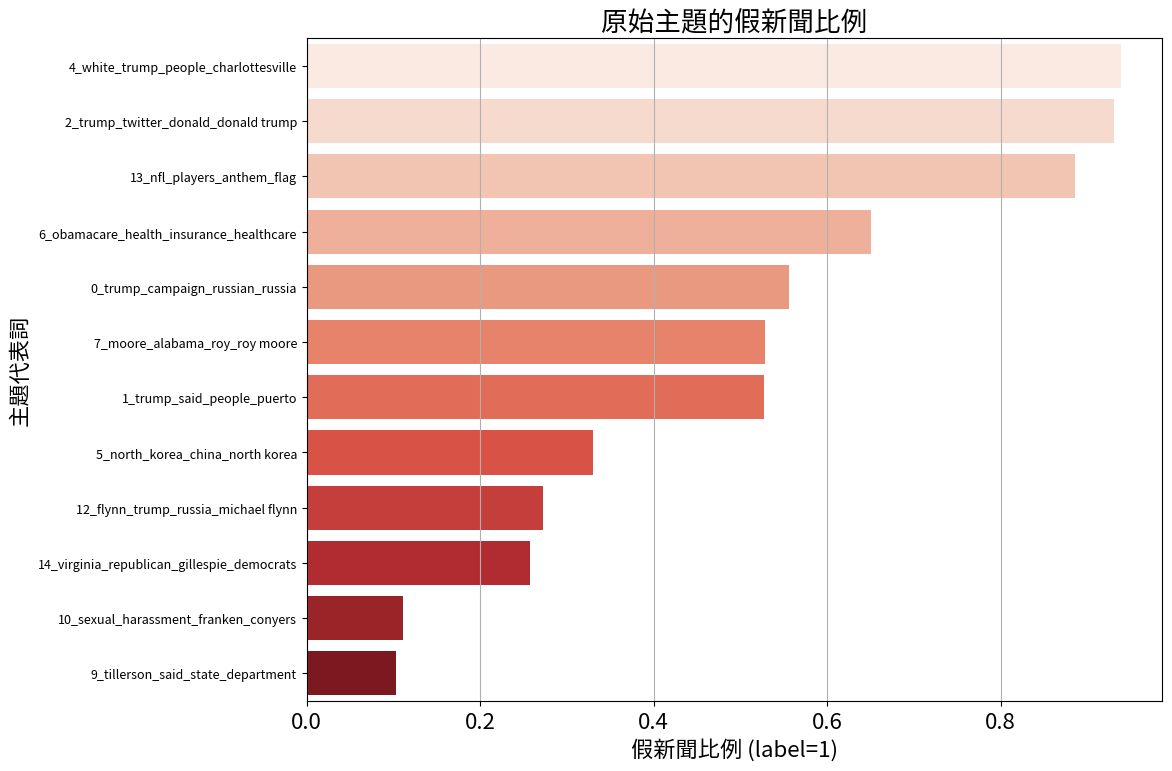

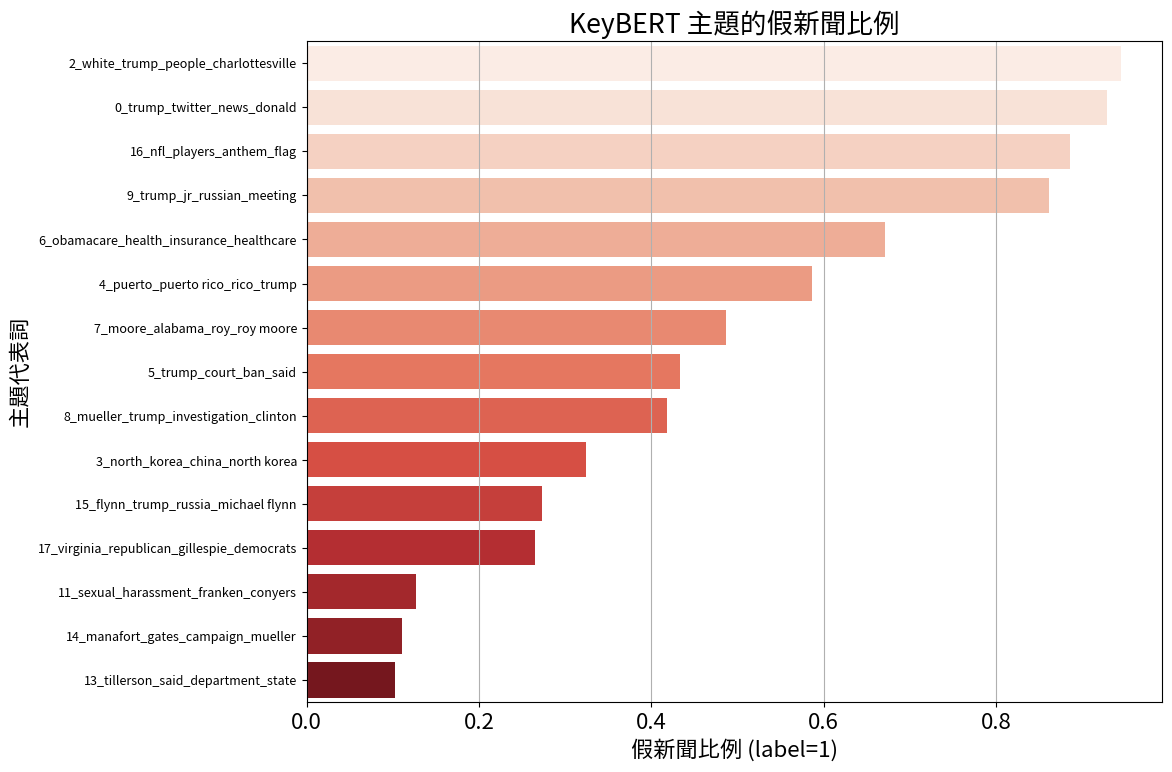

In [75]:
# 原始模型的主題
visualize_fake_news_ratio_by_topic(topic_model, docs, data['label'], title="原始主題的假新聞比例")

# 使用 KeyBERT 表示詞的模型主題
visualize_fake_news_ratio_by_topic(representation_topic_model, docs, data['label'], title="KeyBERT 主題的假新聞比例")